# Guía de Pruebas de Hipótesis: Ejercicios Prácticos
Este cuaderno propone ejercicios similares a problemas resueltos sobre pruebas de hipótesis para medias con desviación estándar conocida. Incluye pasos, código y una interpretación breve para cada caso.

## Configuración del entorno
Importamos las librerías y definimos funciones auxiliares para la prueba z de una muestra (σ conocida) y resumen de resultados.

Funciones z_test_media() y resumen_pruebas() para pruebas z bilaterales con σ conocida.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

def z_test_media(xbar: float, mu0: float, sigma: float, n: int, alpha: float) -> dict:
    """Prueba z bilateral para la media con sigma conocida. Devuelve estadístico, p-valor, z crítico y CI.
    Donde:
    xbar : media muestral
    mu0  : valor poblacional bajo H0
    sigma: desviación estándar poblacional conocida
    n    : tamaño de la muestra
    alpha: nivel de significancia
    """
    se = sigma / np.sqrt(n)                    # error estándar de la media
    z_stat = (xbar - mu0) / se                 # estadístico z
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # p-valor bilateral
    z_crit = norm.ppf(1 - alpha/2)             # z crítico bilateral
    reject = abs(z_stat) > z_crit              # decisión de rechazar H0
    ci_half = z_crit * se                      # margen de error del CI
    return {
        "alpha": alpha,
        "z_stat": z_stat,
        "p_value": p_value,
        "z_crit": z_crit,
        "reject_H0": reject,
        "ci_lower": xbar - ci_half,
        "ci_upper": xbar + ci_half,
        "se": se,
        "n": n,
        "xbar": xbar,
        "mu0": mu0,
        "sigma": sigma
    }

def resumen_pruebas(xbar: float, mu0: float, sigma: float, n: int, alphas: list[float]) -> pd.DataFrame:
    """Genera un resumen de resultados para múltiples niveles de significancia en pruebas z bilaterales.
    Donde:
    xbar : media muestral
    mu0  : valor poblacional bajo H0
    sigma: desviación estándar poblacional conocida
    n    : tamaño de la muestra
    alphas: lista de niveles de significancia
    """
    resultados = [z_test_media(xbar, mu0, sigma, n, a) for a in alphas]
    df = pd.DataFrame(resultados)
    df["confianza"] = (1 - df["alpha"]) * 100
    cols = ["confianza","alpha","z_stat","z_crit","p_value","reject_H0","ci_lower","ci_upper"]
    return df[cols]

def plot_ci_errorbar(tabla: pd.DataFrame, mu0: float, xbar: float, xlabel: str, title: str):
    """Visualiza intervalos de confianza como barras de error horizontales centradas en x̄.
    Donde:
    tabla : DataFrame con columnas 'ci_lower', 'ci_upper', 'confianza', 'alpha'
    mu0   : valor poblacional bajo H0
    xbar  : media muestral
    xlabel: etiqueta del eje x
    title : título del gráfico
    """
    fig, ax = plt.subplots(figsize=(8, 2.8 + 0.5 * len(tabla)))
    y = np.arange(len(tabla))
    left = xbar - tabla['ci_lower'].to_numpy()
    right = tabla['ci_upper'].to_numpy() - xbar
    ax.errorbar(xbar * np.ones_like(y), y, xerr=[left, right],
                fmt='o', color='black', ecolor='steelblue', elinewidth=2, capsize=4, label='x̄ ± CI')
    ax.axvline(mu0, color='red', linestyle='--', lw=1.8, label='μ₀')
    ax.set_yticks(y)
    ax.set_yticklabels([f"{int(c)}% (α={a})" for c, a in zip(tabla['confianza'], tabla['alpha'])])
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, axis='x', alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def plot_sampling_mean_hist(mu0: float, sigma: float, n: int, alpha: float = 0.05,
                            sims: int = 10000, xbar: float | None = None,
                            xlabel: str = 'Media muestral', title: str = 'Distribución de x̄ bajo H0'):
    """Histograma de la distribución de x̄ bajo H0: N(μ0, σ/√n). Marca μ₀, x̄ y umbrales críticos ±zα/2·SE."""
    se = sigma / np.sqrt(n)
    xs = np.random.normal(loc=mu0, scale=se, size=sims)
    zcrit = norm.ppf(1 - alpha/2)
    lower = mu0 - zcrit * se
    upper = mu0 + zcrit * se

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(xs, bins=30, color='tab:blue', alpha=0.7, edgecolor='white')
    ax.axvline(mu0, color='red', linestyle='--', lw=1.8, label='μ₀')
    ax.axvline(lower, color='gray', linestyle=':', lw=1.5, label='Umbral α/2')
    ax.axvline(upper, color='gray', linestyle=':', lw=1.5)
    if xbar is not None:
        ax.axvline(xbar, color='black', lw=1.8, label='x̄')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'{title} (α={alpha})')
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return {"se": se, "lower": lower, "upper": upper}    

## Problema A
Una máquina produce ejes con valor nominal de 1200 mm y desviación estándar conocida de 6 mm. Se toma una muestra aleatoria de 50 ejes y se obtiene una media muestral de 1195 mm. Determine si el largo promedio está dentro de la tolerancia (igual a 1200 mm) con niveles de significancia del 1%, 5% y 10% (prueba bilateral).

**Hipótesis nula ($H_0$):**  
La media poblacional es igual al valor nominal.  
$H_0: \mu = 1200$

**Hipótesis alternativa ($H_1$):**  
La media poblacional es diferente al valor nominal.  
$H_1: \mu \neq 1200$

### Visualización de intervalos (Problema A)
Se muestran los intervalos de confianza sombreados para cada nivel y se marca la media muestral (●) y el valor nulo μ₀ (línea roja discontinua).

   confianza  alpha    z_stat    z_crit       p_value  reject_H0     ci_lower  \
0       99.0   0.01 -5.892557  2.575829  3.802660e-09       True  1192.814336   
1       95.0   0.05 -5.892557  1.959964  3.802660e-09       True  1193.336915   
2       90.0   0.10 -5.892557  1.644854  3.802660e-09       True  1193.604295   

      ci_upper  
0  1197.185664  
1  1196.663085  
2  1196.395705  


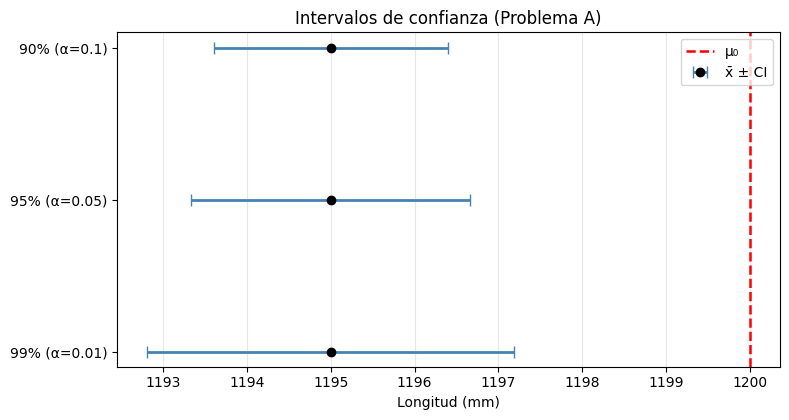

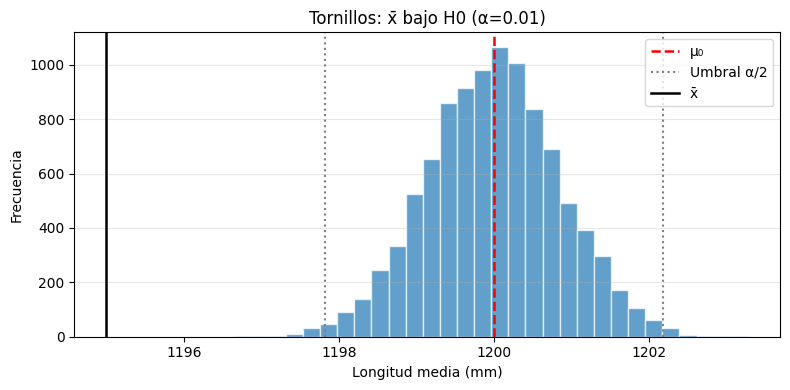

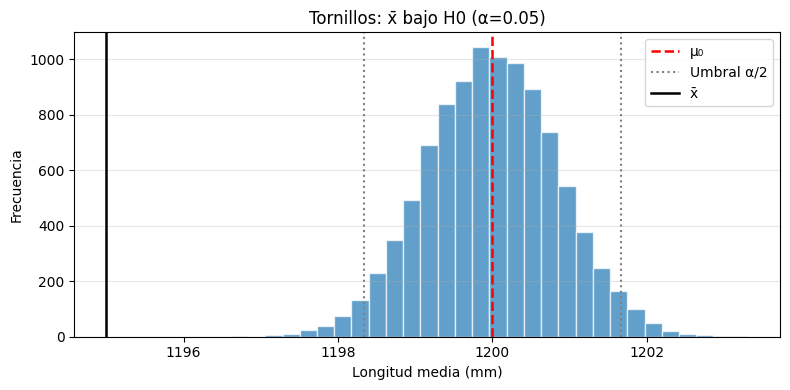

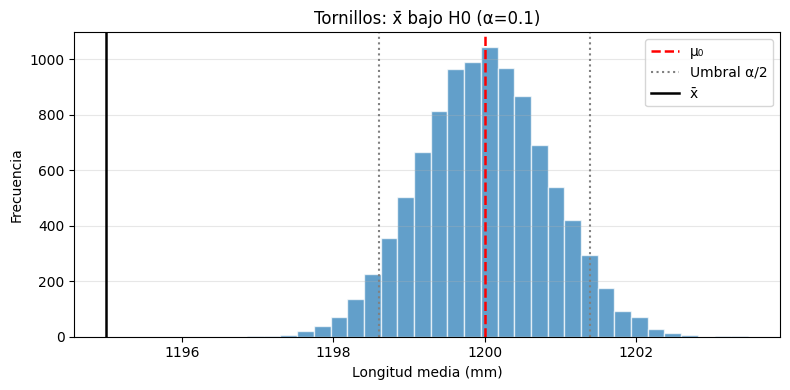

In [2]:
mu0_A = 1200.0                # valor poblacional bajo H0
sigma_A = 6.0                 # desviación estándar conocida
n_A = 50                      # tamaño de la muestra
xbar_A = 1195.0               # media muestral
alphas_A = [0.01, 0.05, 0.10] # niveles de significancia

tabla_A = resumen_pruebas(xbar_A, mu0_A, sigma_A, n_A, alphas_A)
print(tabla_A)

plot_ci_errorbar(tabla_A, mu0_A, xbar_A, xlabel='Longitud (mm)', title='Intervalos de confianza (Problema A)')
for a in alphas_A:
    plot_sampling_mean_hist(mu0_A, sigma_A, n_A, alpha=a, xbar=xbar_A,
                            xlabel='Longitud media (mm)', title='Tornillos: x̄ bajo H0')

Interpretación: Rechazamos $H_0$ cuando `reject_H0=True` a un nivel dado. Si el intervalo de confianza correspondiente no incluye 1200, también se rechaza $H_0$ a ese nivel.

Interpretación del histograma de x̄ bajo H0 (α=0.10):

La línea roja discontinua marca μ₀=1200 mm (media poblacional bajo H0). El histograma muestra dónde deberían caer las medias muestrales si H0 fuera cierta.
Las líneas grises punteadas son los umbrales críticos del test bilateral: μ₀ ± zα/2·SE ≈ [1198.60, 1201.40] mm. Dentro de ese rango no se rechaza H0.
La línea negra es la media observada x̄=1195 mm. Está muy a la izquierda, fuera del rango de no-rechazo y en la cola de la distribución simulada.
Conclusión: x̄ es extremadamente improbable si μ=1200 (z≈-5.89, p≈3.8e-9), por lo que se rechaza H0 a α=0.10 y también a α=0.05 y α=0.01. Indica que el largo promedio es menor que 1200 mm.

## Problema B
Un equipo de investigación cuestiona el estándar histórico de 98.6°F. En una muestra de 200 personas sanas se obtiene $\bar{x}=98.35$°F, con desviación estándar conocida de $\sigma=0.62$°F. ¿Hay evidencia al 1% de que la temperatura promedio poblacional difiera de 98.6°F? (prueba bilateral).

**Hipótesis nula ($H_0$):**  
La temperatura promedio poblacional es igual al estándar histórico.  
$H_0: \mu = 98.6$

**Hipótesis alternativa ($H_1$):**  
La temperatura promedio poblacional es diferente al estándar histórico.  
$H_1: \mu \neq 98.6$

### Visualización de intervalos (Problema B)
Se muestra el intervalo de confianza del 99% sombreado, junto con la media muestral (●) y el valor nulo μ₀ (línea roja discontinua).

   confianza  alpha    z_stat    z_crit       p_value  reject_H0   ci_lower  \
0       99.0   0.01 -5.702474  2.575829  1.180809e-08       True  98.237074   

    ci_upper  
0  98.462926  


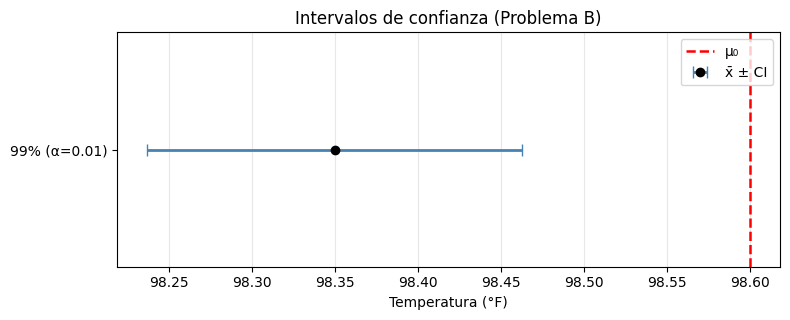

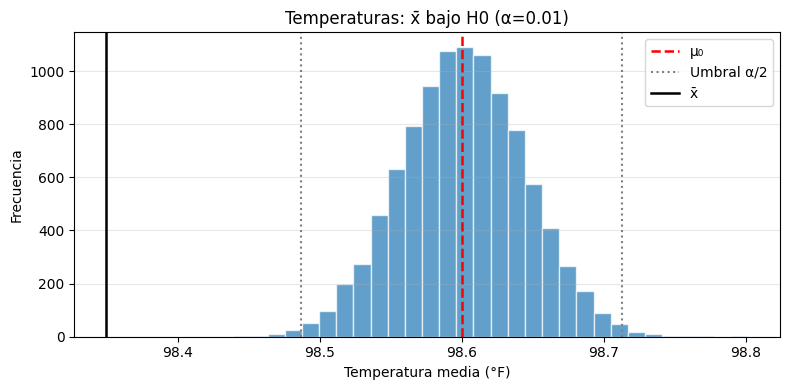

{'se': np.float64(0.043840620433565944),
 'lower': np.float64(98.48707404520145),
 'upper': np.float64(98.71292595479854)}

: 

In [ ]:
mu0_B = 98.6   # valor poblacional bajo H0 (°F)
sigma_B = 0.62 # desviación estándar conocida
n_B = 200      # tamaño de la muestra
xbar_B = 98.35 # media muestral
alpha_B = 0.01 # nivel de significancia
resultado_B = z_test_media(xbar_B, mu0_B, sigma_B, n_B, alpha_B)
tabla_B = resumen_pruebas(xbar_B, mu0_B, sigma_B, n_B, [alpha_B])
print(tabla_B)

plot_ci_errorbar(tabla_B, mu0_B, xbar_B, xlabel='Temperatura (°F)', title='Intervalos de confianza (Problema B)')
plot_sampling_mean_hist(mu0_B, sigma_B, n_B, alpha=alpha_B, xbar=xbar_B,
                            xlabel='Temperatura media (°F)', title='Temperaturas: x̄ bajo H0')

Interpretación: Si `reject_H0=True`, concluimos evidencia al 1% de que la temperatura media difiere de 98.6°F. El intervalo de confianza del 99% debería excluir 98.6°F en ese caso.

Interpretación del histograma B (α=0.01):

Línea roja discontinua: μ₀=98.6°F (lo que se espera bajo H0).
Líneas grises punteadas: umbrales críticos del test bilateral, μ₀ ± zα/2·SE ≈ [98.487, 98.713]°F. Dentro de ese rango no se rechaza H0.
Línea negra: x̄=98.35°F, muy a la izquierda y fuera del rango de no-rechazo.
Evidencia estadística: z ≈ -5.70, p ≈ 1e-8; el IC 99% para la media muestral ≈ [98.237, 98.463]°F no contiene 98.6°F.
Conclusión: se rechaza H0 al 1%. La media poblacional es menor que 98.6°F.